#Credit Card Behaviour Score Prediction Using Classification and Risk-Based Techniques
#submitted by Mahfooj Ali , Enrollment number-**22118045**

Importing  Required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


LOADING AND EXPLORING DATA


In [2]:
print("="*50)
print("LOADING AND EXPLORING DATA")
print("="*50)

# Load data
df = pd.read_csv('/content/train_dataset_final1.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

print(f"\nDataset Info:")
print(df.info())

print(f"\nMissing values:")
print(df.isnull().sum())

print(f"\nTarget variable distribution:")
print(df['next_month_default'].value_counts())
print(f"Default rate: {df['next_month_default'].mean():.3f}")


LOADING AND EXPLORING DATA
Dataset shape: (25247, 27)

First few rows:
   Customer_ID  marriage  sex  education  LIMIT_BAL   age  pay_0  pay_2  \
0         5017         2    0          2      60000  25.0      2      2   
1         5018         2    1          1     290000  24.0      0      0   
2         5019         1    0          2     180000  63.0      0      0   
3         5020         1    1          2     210000  43.0      0      0   
4         5021         2    0          1     280000  32.0     -2     -2   

   pay_3  pay_4  ...  Bill_amt6  pay_amt1  pay_amt2  pay_amt3  pay_amt4  \
0      2      0  ...   20750.63   2000.21      0.00   1134.85   1821.78   
1     -2     -2  ...    1350.30      0.00      0.17      0.00   2700.10   
2      0      0  ...   52991.51   2086.94   2199.99   1845.66   2000.35   
3      0      0  ...   76945.47   3348.07   3380.91   3400.45   2683.97   
4     -2     -2  ...       1.35    999.78   3186.27  45027.78   2100.09   

   pay_amt5  pay_amt6  AVG_

DATA PREPROCESSING

In [3]:
print("\n" + "="*50)
print("DATA PREPROCESSING")
print("="*50)

# Handle missing values in age column
if df['age'].isnull().sum() > 0:
    df['age'].fillna(df['age'].median(), inplace=True)
    print(f"Filled missing age values with median: {df['age'].median()}")

# Remove any remaining rows with missing critical values
initial_shape = df.shape[0]
df = df.dropna()
final_shape = df.shape[0]
print(f"Removed {initial_shape - final_shape} rows with missing values")

# Handle categorical variables
# Marriage: 1=married, 2=single, 3=divorce, 0=others
# Sex: 1=male, 2=female -> convert to 0=female, 1=male
df['sex'] = df['sex'].map({1: 1, 2: 0})  # 1=male, 0=female

# Education: 1=graduate school, 2=university, 3=high school, 4=others
# Keep as is for now

print("Categorical variables processed")
print(f"Final dataset shape: {df.shape}")



DATA PREPROCESSING
Filled missing age values with median: 34.0
Removed 0 rows with missing values
Categorical variables processed
Final dataset shape: (25247, 27)


PERFORMING EXPLORATORY DATA ANALYSIS(EDA)


EXPLORATORY DATA ANALYSIS


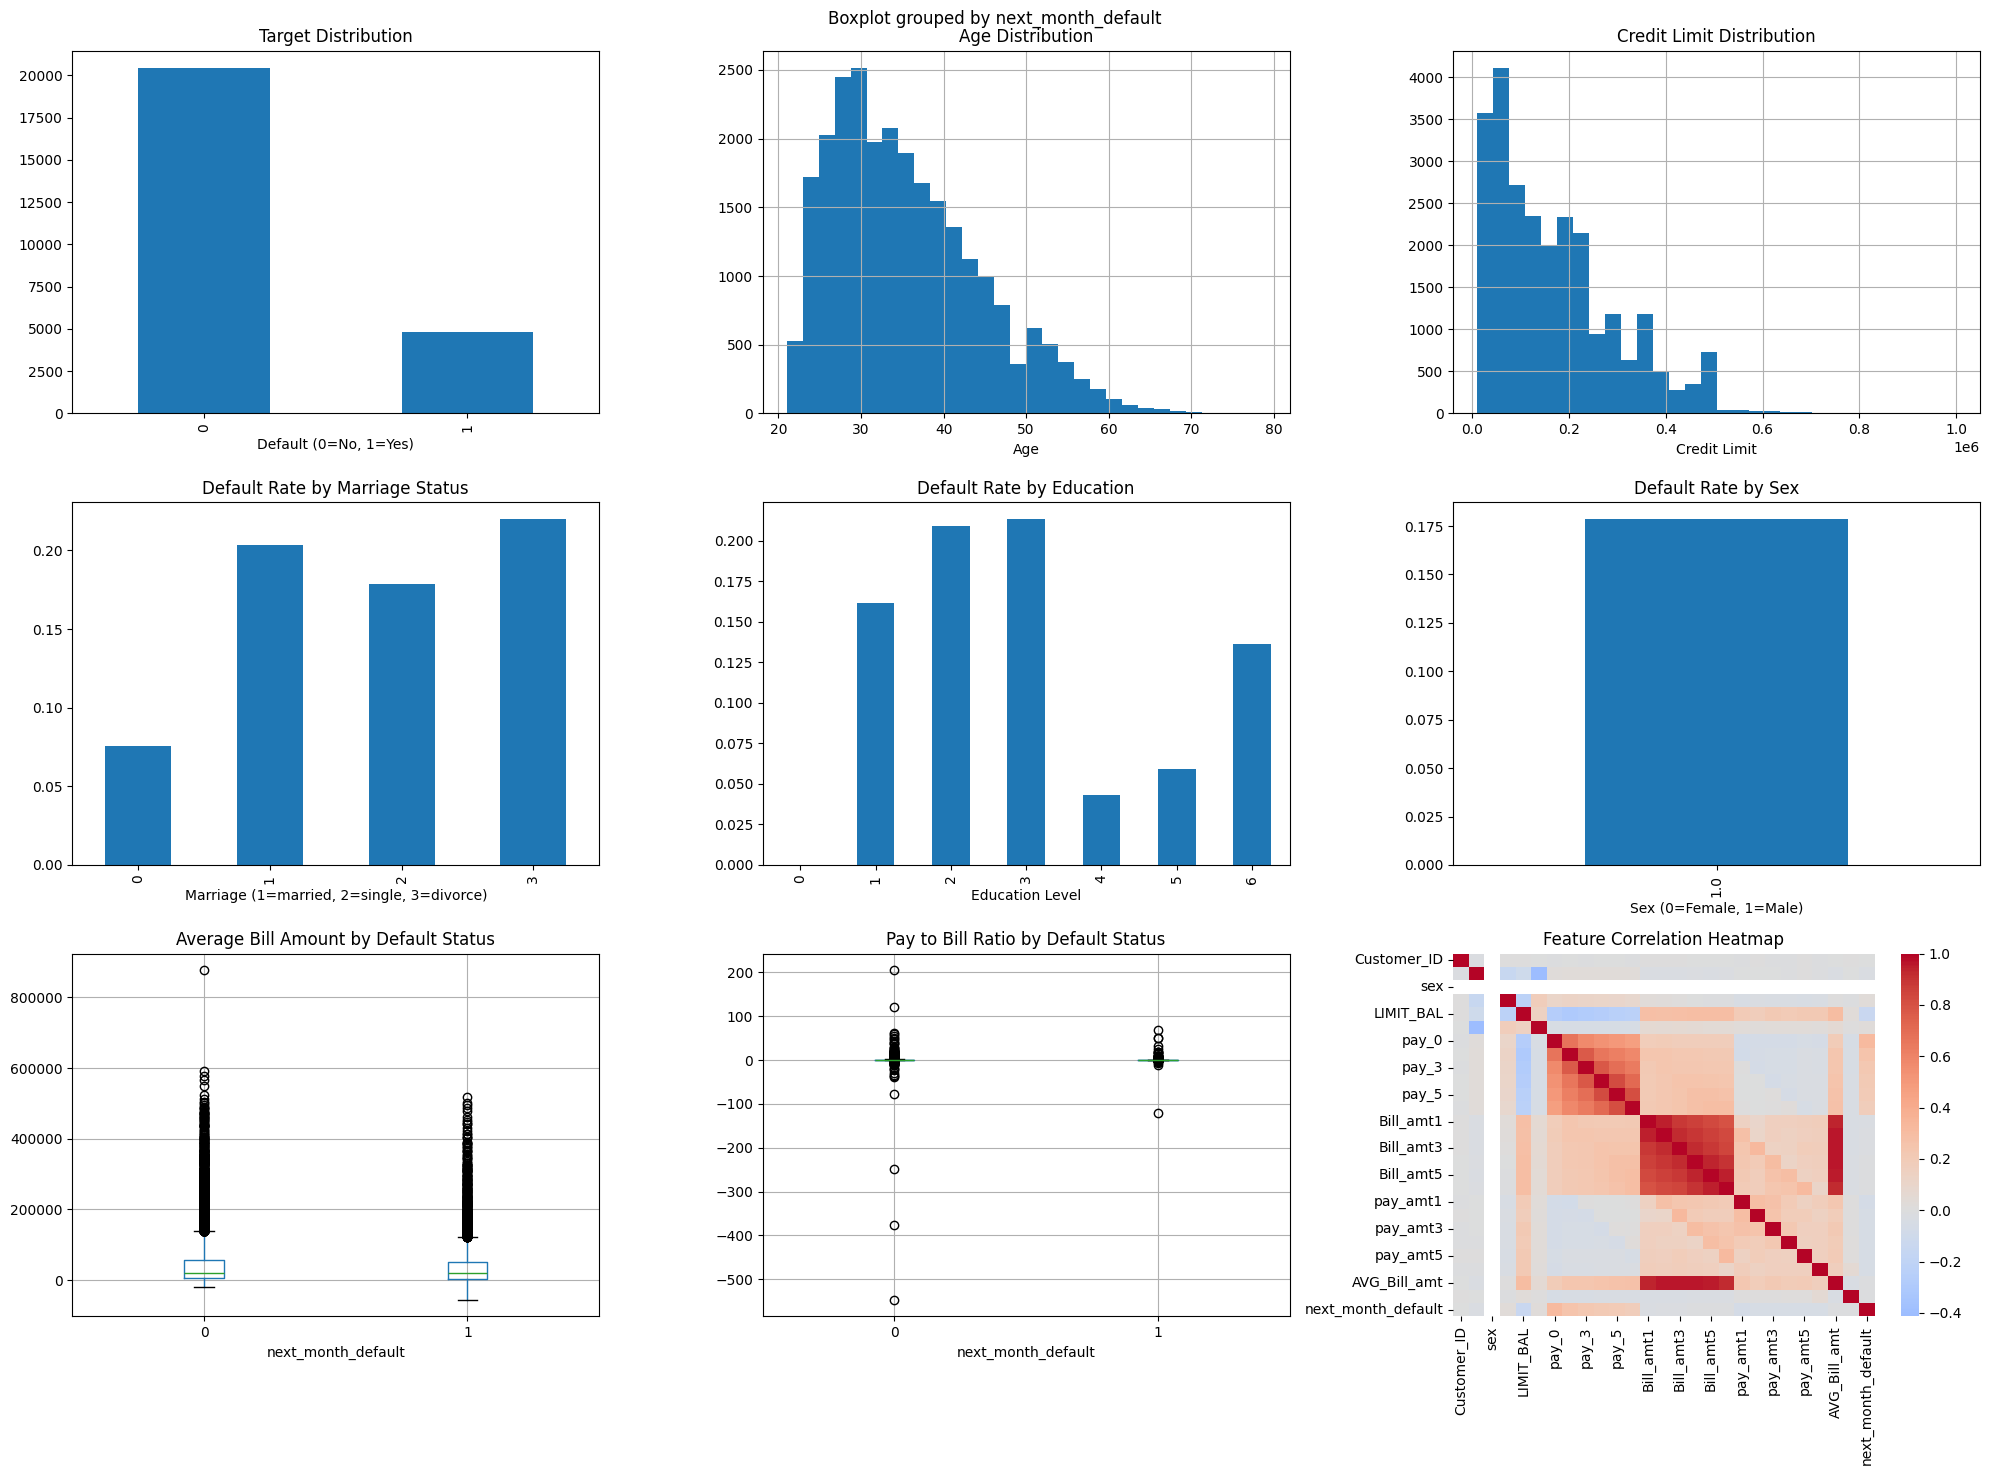


Key Statistics:
Average age: 35.4
Average credit limit: $168,342
Average bill amount: $44,859.65
Average pay to bill ratio: 0.363


In [4]:
print("\n" + "="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

# Set up the plotting style
plt.style.use('default')
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Credit Card Default Prediction - EDA', fontsize=16, fontweight='bold')

# 1. Target distribution
df['next_month_default'].value_counts().plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Target Distribution')
axes[0,0].set_xlabel('Default (0=No, 1=Yes)')

# 2. Age distribution
df['age'].hist(bins=30, ax=axes[0,1])
axes[0,1].set_title('Age Distribution')
axes[0,1].set_xlabel('Age')

# 3. Credit limit distribution
df['LIMIT_BAL'].hist(bins=30, ax=axes[0,2])
axes[0,2].set_title('Credit Limit Distribution')
axes[0,2].set_xlabel('Credit Limit')

# 4. Default rate by marriage status
marriage_default = df.groupby('marriage')['next_month_default'].mean()
marriage_default.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Default Rate by Marriage Status')
axes[1,0].set_xlabel('Marriage (1=married, 2=single, 3=divorce)')

# 5. Default rate by education
edu_default = df.groupby('education')['next_month_default'].mean()
edu_default.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Default Rate by Education')
axes[1,1].set_xlabel('Education Level')

# 6. Default rate by sex
sex_default = df.groupby('sex')['next_month_default'].mean()
sex_default.plot(kind='bar', ax=axes[1,2])
axes[1,2].set_title('Default Rate by Sex')
axes[1,2].set_xlabel('Sex (0=Female, 1=Male)')

# 7. Average bill amount vs default
df.boxplot(column='AVG_Bill_amt', by='next_month_default', ax=axes[2,0])
axes[2,0].set_title('Average Bill Amount by Default Status')

# 8. Pay to Bill ratio vs default
df.boxplot(column='PAY_TO_BILL_ratio', by='next_month_default', ax=axes[2,1])
axes[2,1].set_title('Pay to Bill Ratio by Default Status')

# 9. Correlation heatmap
# Select numeric columns for correlation
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, ax=axes[2,2])
axes[2,2].set_title('Feature Correlation Heatmap')

plt.tight_layout()
plt.show()

# Print some statistics
print("\nKey Statistics:")
print(f"Average age: {df['age'].mean():.1f}")
print(f"Average credit limit: ${df['LIMIT_BAL'].mean():,.0f}")
print(f"Average bill amount: ${df['AVG_Bill_amt'].mean():,.2f}")
print(f"Average pay to bill ratio: {df['PAY_TO_BILL_ratio'].mean():.3f}")

Financial insights from key variables



In [5]:
print("=== FINANCIAL DATASET OVERVIEW ===")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few rows:")
print(df.head())

print("\n=== BASIC STATISTICS ===")
print(df.describe())

print("\n=== MISSING VALUES ===")
print(df.isnull().sum())


=== FINANCIAL DATASET OVERVIEW ===
Dataset shape: (25247, 27)
Columns: ['Customer_ID', 'marriage', 'sex', 'education', 'LIMIT_BAL', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio', 'next_month_default']

First few rows:
   Customer_ID  marriage  sex  education  LIMIT_BAL   age  pay_0  pay_2  \
0         5017         2  NaN          2      60000  25.0      2      2   
1         5018         2  1.0          1     290000  24.0      0      0   
2         5019         1  NaN          2     180000  63.0      0      0   
3         5020         1  1.0          2     210000  43.0      0      0   
4         5021         2  NaN          1     280000  32.0     -2     -2   

   pay_3  pay_4  ...  Bill_amt6  pay_amt1  pay_amt2  pay_amt3  pay_amt4  \
0      2      0  ...   20750.63   2000.21      0.00   1

FEATURE ENGINEERING

In [6]:
print("\n" + "="*50)
print("FEATURE ENGINEERING")
print("="*50)

# 1. Age groups
df['age_group'] = pd.cut(df['age'],
                        bins=[0, 30, 45, 60, 100],
                        labels=['Young', 'Adult', 'Middle', 'Senior'])
df['age_group'] = LabelEncoder().fit_transform(df['age_group'])

# 2. Credit utilization (based on bill amounts vs limit)
bill_columns = ['Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6']
df['max_bill'] = df[bill_columns].max(axis=1)
df['credit_utilization'] = df['max_bill'] / df['LIMIT_BAL']
df['credit_utilization'] = df['credit_utilization'].clip(0, 2)  # Cap at 200%

# 3. Payment consistency (standard deviation of payment status)
pay_columns = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
df['payment_consistency'] = df[pay_columns].std(axis=1)

# 4. Recent payment behavior (focus on pay_0, pay_2, pay_3)
df['recent_pay_sum'] = df[['pay_0', 'pay_2', 'pay_3']].sum(axis=1)

# 5. Bill trend (is the person's bill increasing?)
df['bill_trend'] = (df['Bill_amt1'] - df['Bill_amt6']) / (df['Bill_amt6'] + 1)

# 6. Payment amount consistency
pay_amt_columns = ['pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
df['avg_payment'] = df[pay_amt_columns].mean(axis=1)
df['payment_volatility'] = df[pay_amt_columns].std(axis=1)

# 7. High risk payment status (any payment status >= 2)
df['high_risk_payments'] = (df[pay_columns] >= 2).sum(axis=1)

# 8. Bill amount categories
df['bill_category'] = pd.cut(df['AVG_Bill_amt'],
                            bins=[-np.inf, 0, 10000, 50000, np.inf],
                            labels=['Negative', 'Low', 'Medium', 'High'])
df['bill_category'] = LabelEncoder().fit_transform(df['bill_category'])

print("New features created:")
new_features = ['age_group', 'credit_utilization', 'payment_consistency',
               'recent_pay_sum', 'bill_trend', 'avg_payment',
               'payment_volatility', 'high_risk_payments', 'bill_category']

for feature in new_features:
    print(f"- {feature}")

print(f"\nTotal features now: {len(df.columns)}")


FEATURE ENGINEERING
New features created:
- age_group
- credit_utilization
- payment_consistency
- recent_pay_sum
- bill_trend
- avg_payment
- payment_volatility
- high_risk_payments
- bill_category

Total features now: 37


PREPARING FEATURES FOR MODELING

In [7]:
print("\n" + "="*50)
print("PREPARING FEATURES FOR MODELING")
print("="*50)

# Define features to use for modeling
feature_columns = [
    'marriage', 'sex', 'education', 'LIMIT_BAL', 'age',
    'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6',
    'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6',
    'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
    'AVG_Bill_amt', 'PAY_TO_BILL_ratio',
    # Engineered features
    'age_group', 'credit_utilization', 'payment_consistency',
    'recent_pay_sum', 'bill_trend', 'avg_payment',
    'payment_volatility', 'high_risk_payments', 'bill_category'
]

# Prepare X and y
X = df[feature_columns].copy()
y = df['next_month_default'].copy()

# Handle any infinite or NaN values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

print(f"Selected {len(feature_columns)} features for modeling")
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Store feature names for later use
feature_names = feature_columns



PREPARING FEATURES FOR MODELING
Selected 34 features for modeling
Feature matrix shape: (25247, 34)
Target vector shape: (25247,)


INITIALIZING MACHINE LEARNING MODELS

In [8]:
print("\n" + "="*50)
print("INITIALIZING MACHINE LEARNING MODELS")
print("="*50)

# Initialize scaler
scaler = StandardScaler()

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'AdaBoost': AdaBoostClassifier(random_state=42, n_estimators=100),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier(random_state=42, max_iter=500)
}

print(f"Initialized {len(models)} models:")
for name in models.keys():
    print(f"- {name}")



INITIALIZING MACHINE LEARNING MODELS
Initialized 8 models:
- Logistic Regression
- Random Forest
- Gradient Boosting
- AdaBoost
- Decision Tree
- SVM
- Naive Bayes
- Neural Network


TRAINING AND EVALUATING MODELS

In [9]:
print("\n" + "="*50)
print("TRAINING AND EVALUATING MODELS")
print("="*50)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Evaluate models
results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Model Performance:")
print("-" * 80)
print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'ROC-AUC':<10}")
print("-" * 80)

for name, model in models.items():
    # Use scaled data for models that benefit from it
    if name in ['Logistic Regression', 'SVM', 'Neural Network']:
        X_train_use, X_test_use = X_train_scaled, X_test_scaled
    else:
        X_train_use, X_test_use = X_train, X_test

    # Train model
    model.fit(X_train_use, y_train)

    # Predictions
    y_pred = model.predict(X_test_use)
    y_pred_proba = model.predict_proba(X_test_use)[:, 1] if hasattr(model, 'predict_proba') else y_pred

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    print(f"{name:<20} {accuracy:<10.4f} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f} {roc_auc:<10.4f}")


TRAINING AND EVALUATING MODELS
Model Performance:
--------------------------------------------------------------------------------
Model                Accuracy   Precision  Recall     F1-Score   ROC-AUC   
--------------------------------------------------------------------------------
Logistic Regression  0.8354     0.6625     0.2775     0.3912     0.7701    
Random Forest        0.8364     0.6441     0.3160     0.4240     0.7739    
Gradient Boosting    0.8448     0.6718     0.3617     0.4703     0.7886    
AdaBoost             0.8440     0.6768     0.3462     0.4580     0.7839    
Decision Tree        0.7541     0.3696     0.4127     0.3900     0.6235    
SVM                  0.8442     0.6906     0.3295     0.4462     0.7136    
Naive Bayes          0.3434     0.2126     0.9054     0.3444     0.6981    
Neural Network       0.8345     0.6296     0.3181     0.4227     0.7681    


SELECTING BEST MODEL AND MODEL COMPARISON VISUALIZATION


SELECTING BEST MODEL
Best Model: Gradient Boosting
Best ROC-AUC Score: 0.7886

Detailed Results for Gradient Boosting:
Accuracy: 0.8448
Precision: 0.6718
Recall: 0.3617
F1-Score: 0.4703
ROC-AUC: 0.7886

MODEL COMPARISON VISUALIZATION


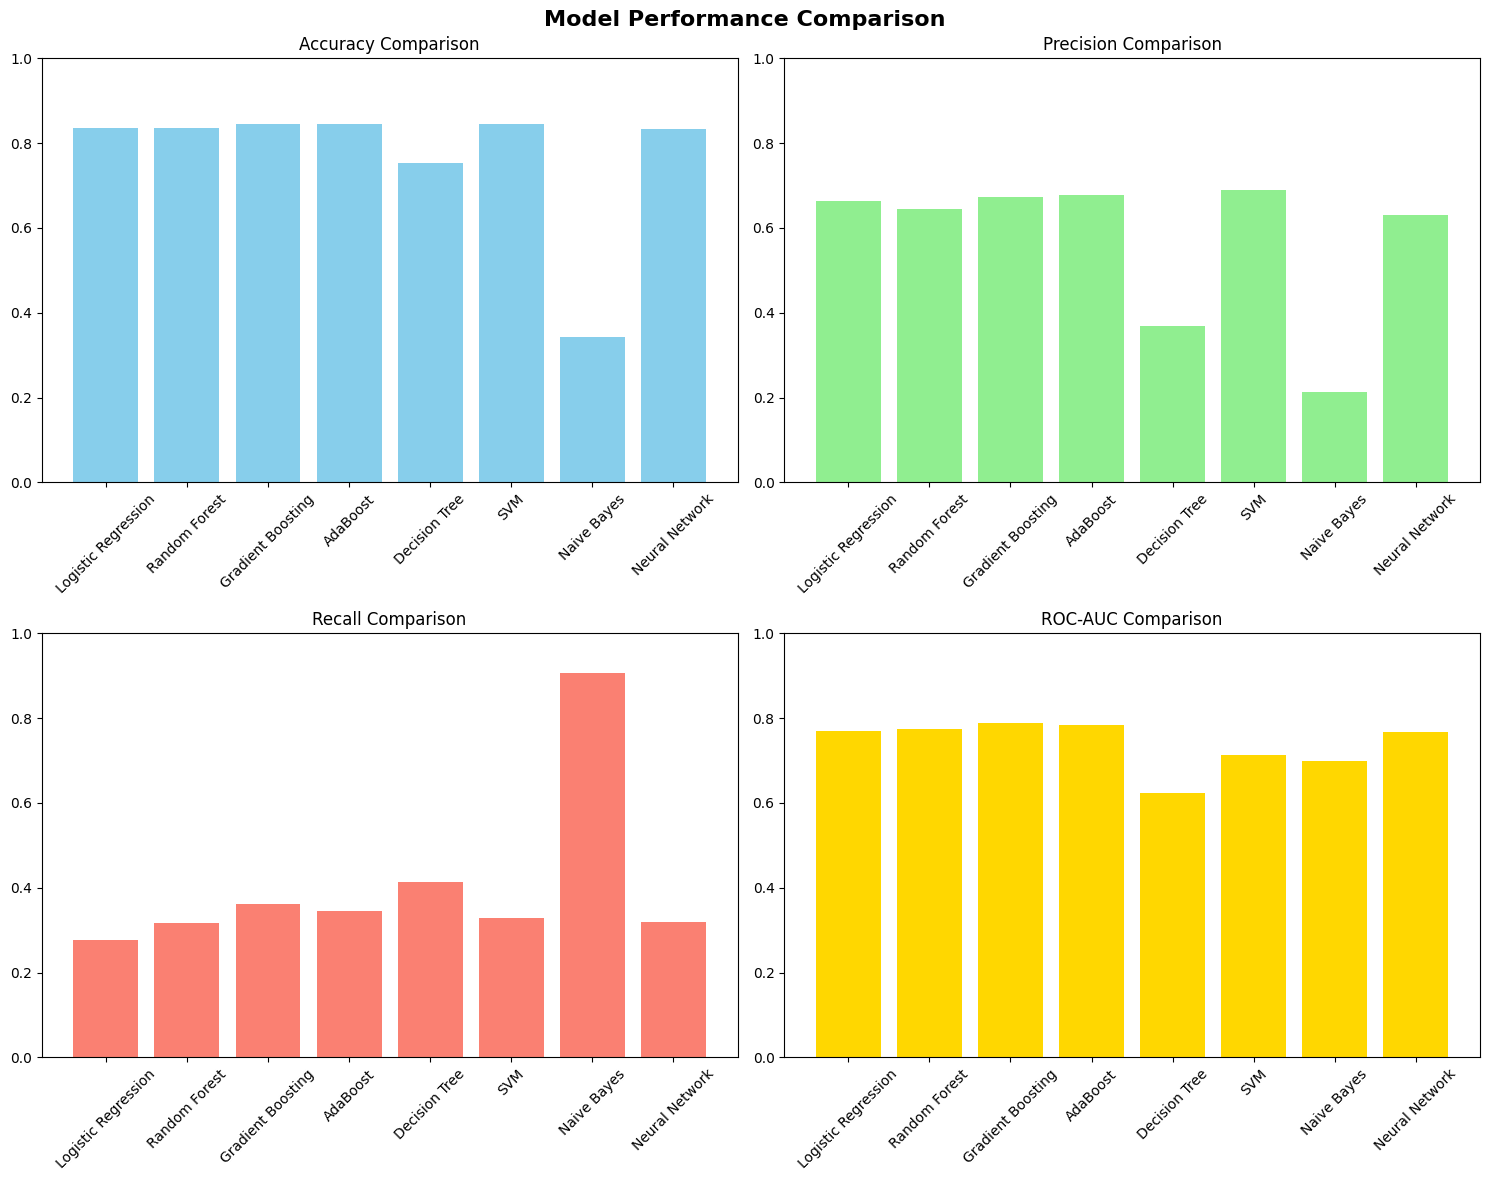

In [10]:
print("\n" + "="*50)
print("SELECTING BEST MODEL")
print("="*50)

# Find best model based on ROC-AUC
best_score = 0
best_name = None

for name, result in results.items():
    if result['roc_auc'] > best_score:
        best_score = result['roc_auc']
        best_name = name

best_model = results[best_name]['model']

print(f"Best Model: {best_name}")
print(f"Best ROC-AUC Score: {best_score:.4f}")

# Show detailed results for best model
print(f"\nDetailed Results for {best_name}:")
print(f"Accuracy: {results[best_name]['accuracy']:.4f}")
print(f"Precision: {results[best_name]['precision']:.4f}")
print(f"Recall: {results[best_name]['recall']:.4f}")
print(f"F1-Score: {results[best_name]['f1']:.4f}")
print(f"ROC-AUC: {results[best_name]['roc_auc']:.4f}")

#  MODEL COMPARISON VISUALIZATION

print("\n" + "="*50)
print("MODEL COMPARISON VISUALIZATION")
print("="*50)

# Extract metrics for plotting
model_names = list(results.keys())
accuracies = [results[model]['accuracy'] for model in model_names]
precisions = [results[model]['precision'] for model in model_names]
recalls = [results[model]['recall'] for model in model_names]
f1_scores = [results[model]['f1'] for model in model_names]
roc_aucs = [results[model]['roc_auc'] for model in model_names]

# Create comparison plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

# Accuracy
axes[0,0].bar(model_names, accuracies, color='skyblue')
axes[0,0].set_title('Accuracy Comparison')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].set_ylim(0, 1)

# Precision
axes[0,1].bar(model_names, precisions, color='lightgreen')
axes[0,1].set_title('Precision Comparison')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].set_ylim(0, 1)

# Recall
axes[1,0].bar(model_names, recalls, color='salmon')
axes[1,0].set_title('Recall Comparison')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].set_ylim(0, 1)

# ROC-AUC
axes[1,1].bar(model_names, roc_aucs, color='gold')
axes[1,1].set_title('ROC-AUC Comparison')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].set_ylim(0, 1)

plt.tight_layout()
plt.show()


ROC Curve Comparison for All Models

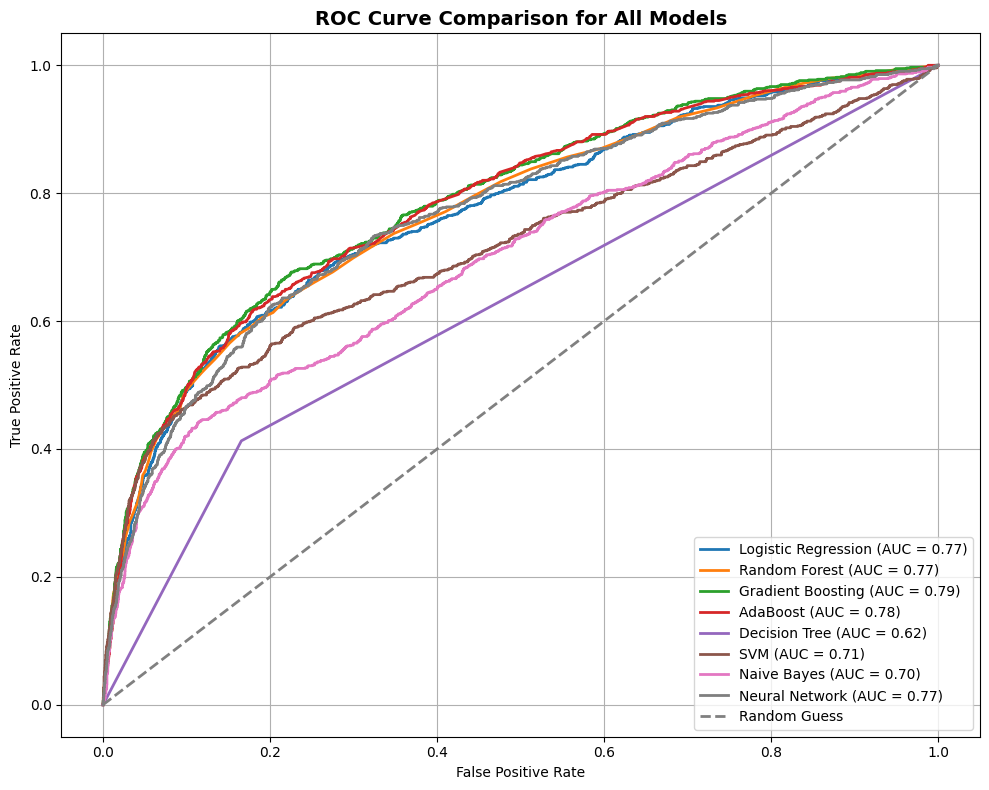

In [14]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))
plt.title("ROC Curve Comparison for All Models", fontsize=14, fontweight='bold')

# Plot ROC curve for each model
for name, result in results.items():
    if 'y_pred_proba' in result:
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guess')

# Formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


FEATURE IMPORTANCE ANALYSIS


FEATURE IMPORTANCE ANALYSIS
Top 15 Most Important Features:
                feature  importance
28       recent_pay_sum    0.358172
5                 pay_0    0.219472
32   high_risk_payments    0.150135
26   credit_utilization    0.040797
30          avg_payment    0.023883
11            Bill_amt1    0.022480
23         AVG_Bill_amt    0.021602
29           bill_trend    0.019775
27  payment_consistency    0.019179
3             LIMIT_BAL    0.014620
19             pay_amt3    0.012752
17             pay_amt1    0.012148
4                   age    0.009904
31   payment_volatility    0.008717
2             education    0.006810


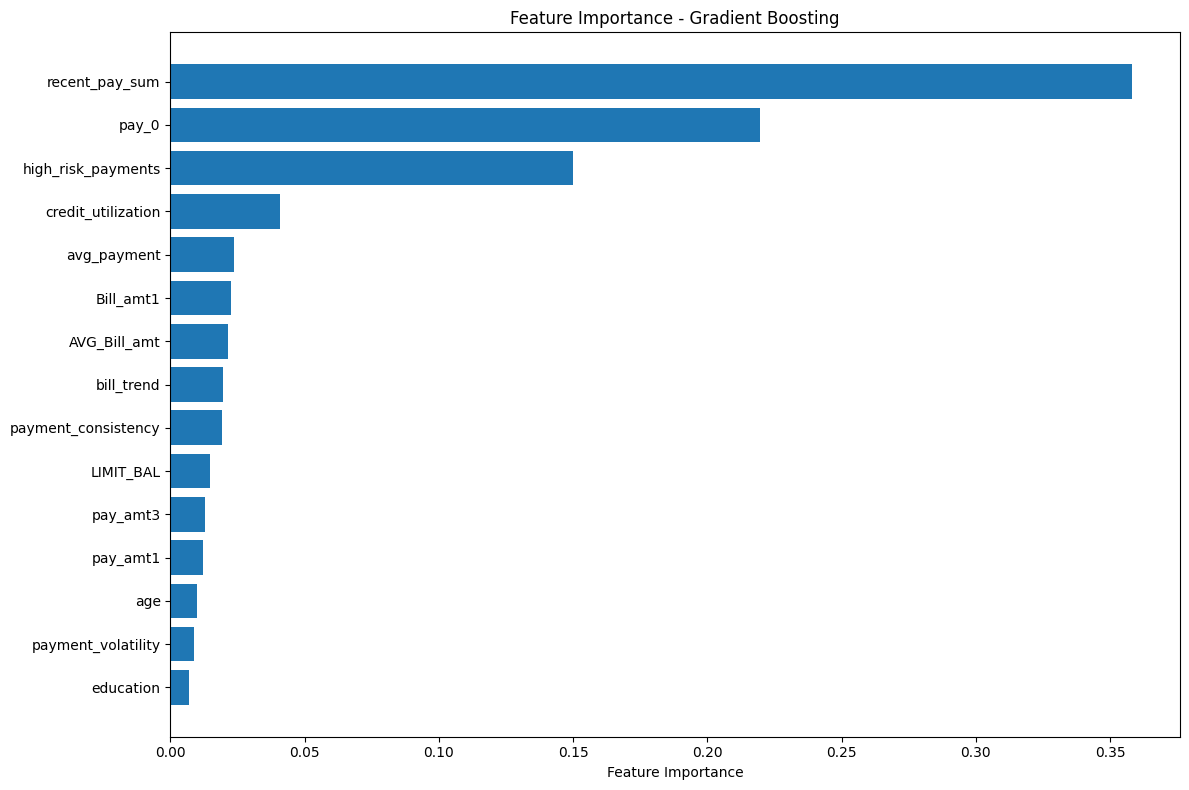

In [11]:
# Feature Importance Analysis
print("\n" + "="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)

# Check if best model has feature importance
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    print("Top 15 Most Important Features:")
    print(feature_importance_df.head(15))

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance - {best_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

else:
    print(f"Feature importance not available for {best_name}")


CREATING VALIDATION FUNCTION AND OUTPUT(prediction.csv)

In [12]:
# CELL 12: Create Validation Function
print("\n" + "="*50)
print("CREATING VALIDATION FUNCTION")
print("="*50)

def validate_and_predict(validation_file_path, output_file_path='predictions.csv'):
    """
    Function to validate model on test dataset and create submission file
    """
    # Load validation/test data
    val_df = pd.read_csv('/content/validate_dataset_final.csv')
    print(f"Validation dataset shape: {val_df.shape}")

    # Apply same preprocessing and feature engineering and Handle missing values
    if 'age' in val_df.columns and val_df['age'].isnull().sum() > 0:
        val_df['age'].fillna(val_df['age'].median(), inplace=True)

    val_df = val_df.dropna()

    # Handle categorical variables
    if 'sex' in val_df.columns:
        val_df['sex'] = val_df['sex'].map({1: 1, 2: 0})

    # Feature engineering (same as training)
    if 'age' in val_df.columns:
        val_df['age_group'] = pd.cut(val_df['age'],
                                   bins=[0, 30, 45, 60, 100],
                                   labels=['Young', 'Adult', 'Middle', 'Senior'])
        val_df['age_group'] = LabelEncoder().fit_transform(val_df['age_group'])

    # Credit utilization
    bill_columns = ['Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6']
    if all(col in val_df.columns for col in bill_columns + ['LIMIT_BAL']):
        val_df['max_bill'] = val_df[bill_columns].max(axis=1)
        val_df['credit_utilization'] = val_df['max_bill'] / val_df['LIMIT_BAL']
        val_df['credit_utilization'] = val_df['credit_utilization'].clip(0, 2)

    # Payment consistency
    pay_columns = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
    if all(col in val_df.columns for col in pay_columns):
        val_df['payment_consistency'] = val_df[pay_columns].std(axis=1)
        val_df['recent_pay_sum'] = val_df[['pay_0', 'pay_2', 'pay_3']].sum(axis=1)
        val_df['high_risk_payments'] = (val_df[pay_columns] >= 2).sum(axis=1)

    # Bill trend
    if 'Bill_amt1' in val_df.columns and 'Bill_amt6' in val_df.columns:
        val_df['bill_trend'] = (val_df['Bill_amt1'] - val_df['Bill_amt6']) / (val_df['Bill_amt6'] + 1)

    # Payment amounts
    pay_amt_columns = ['pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
    if all(col in val_df.columns for col in pay_amt_columns):
        val_df['avg_payment'] = val_df[pay_amt_columns].mean(axis=1)
        val_df['payment_volatility'] = val_df[pay_amt_columns].std(axis=1)

    # Bill category
    if 'AVG_Bill_amt' in val_df.columns:
        val_df['bill_category'] = pd.cut(val_df['AVG_Bill_amt'],
                                       bins=[-np.inf, 0, 10000, 50000, np.inf],
                                       labels=['Negative', 'Low', 'Medium', 'High'])
        val_df['bill_category'] = LabelEncoder().fit_transform(val_df['bill_category'])

    # Prepare features
    available_features = [col for col in feature_names if col in val_df.columns]
    X_val = val_df[available_features].copy()

    # Handle missing engineered features
    for feature in feature_names:
        if feature not in X_val.columns:
            X_val[feature] = 0  # Default value for missing features

    # Reorder columns to match training
    X_val = X_val[feature_names]

    # Handle infinite/NaN values
    X_val = X_val.replace([np.inf, -np.inf], np.nan)
    X_val = X_val.fillna(X_val.median())

    # Apply scaling if needed
    if best_name in ['Logistic Regression', 'SVM', 'Neural Network']:
        X_val_scaled = scaler.transform(X_val)
        predictions = best_model.predict(X_val_scaled)
    else:
        predictions = best_model.predict(X_val)

    # Create submission dataframe
    submission_df = pd.DataFrame({
        'Customer': val_df['Customer_ID'],
        'next_month_default': predictions
    })

    # Save to CSV
    submission_df.to_csv(output_file_path, index=False)
    print(f"Predictions saved to: {output_file_path}")
    print(f"Prediction distribution:")
    print(submission_df['next_month_default'].value_counts())
    print(f"Default rate: {submission_df['next_month_default'].mean():.3f}")

    return submission_df




CREATING VALIDATION FUNCTION


In [13]:
validate_and_predict('/content/validate_dataset_final.csv')

Validation dataset shape: (5016, 26)
Predictions saved to: predictions.csv
Prediction distribution:
next_month_default
0    4486
1     530
Name: count, dtype: int64
Default rate: 0.106


,Customer,next_month_default
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
5011,5012,0
5012,5013,0
5013,5014,0
5014,5015,0
